# How to map faults in 3-D

This tutorial describes how to map tectonic faults in a 3-D seismic volume using a 3-D convolutional neural network, but only 2-D labels using a masked loss function. Using 2-D labels is really useful, because 3-D labelling is really time-consuming (you would need to label a large number of closely-spaced 2-D lines). So this is a nice trick! Huge thanks to Valentin Tschannen and co-authors for showing us how to do this! Check out their excellent paper: [https://doi.org/10.1190/geo2019-0569.1](https://doi.org/10.1190/geo2019-0569.1)

## Setup ##
1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-4/tutorial-4.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


## Pre-processing ##
Now that everything is set up, we need to install and load a couple of python packages, we will use:


In [2]:
!pip install googledrivedownloader
!pip install segpy

In [3]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from google_drive_downloader import GoogleDriveDownloader as gdd

import segpy
from segpy.reader import create_reader

from google.colab import widgets

and clone our git repository:

In [4]:
!git clone https://github.com/thilowrona/seismic_deep_learning

fatal: destination path 'seismic_deep_learning' already exists and is not an empty directory.


and download the 3-D seismic volume:

In [5]:
gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

and load the data:

In [6]:
filename = "./Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

data = (data-np.min(data))/(np.max(data)-np.min(data))

and plot it:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

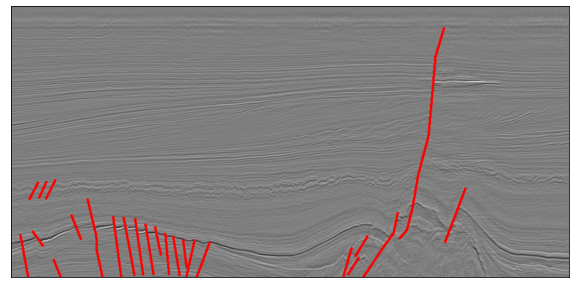

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

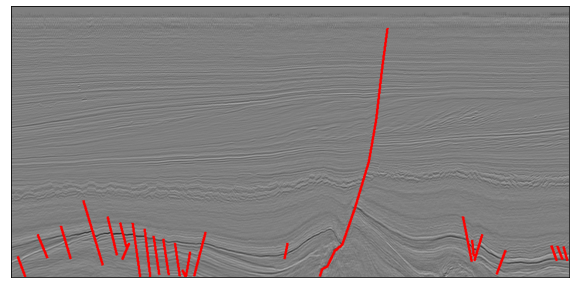

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

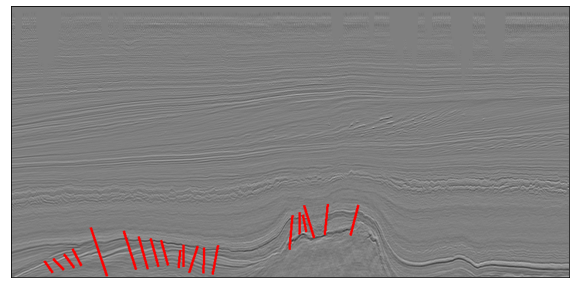

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

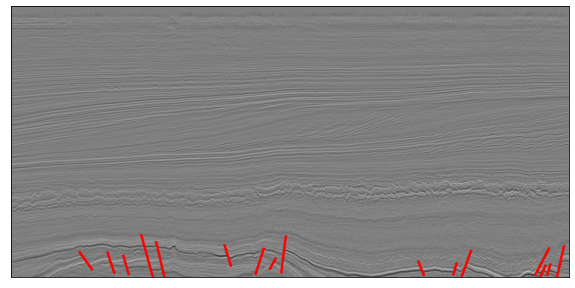

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

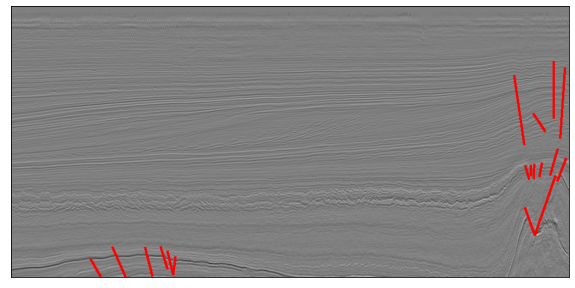

<IPython.core.display.Javascript object>

In [39]:
def load_label(inline):
    label = Image.open('./seismic_deep_learning/tutorial-3/mask_inline_' + str(inline) + '.png')
    label.load()
    label = np.asarray(label)[:,:,3]
    label = np.where(label > 0.5, 1, 0)
    return label


def plot_overlay(image, label):
    (tmax, xmax) = np.shape(image)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
    image_rgb = np.zeros((tmax,xmax,4), 'uint8')    
    image_rgb[:,:,0] = 255*image
    image_rgb[:,:,1] = 255*image
    image_rgb[:,:,2] = 255*image
    image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGBA')    
    background.paste(img, (0, 0), img)

    plt.imshow(background)
    plt.xticks([])
    plt.yticks([])



tb = widgets.TabBar([str(i) for i in range(100,501,100)])

for i in range(5): 
  with tb.output_to(i):
    plt.figure(figsize=(10,10))
    label = load_label(100+100*i)
    plot_overlay(data[100+100*i,:,:], label)
    plt.xticks([])
    plt.yticks([])

Now we can define function (cubify), which generates our training examples:

In [29]:
def cubify(data, inline, batch_size, size, n_classes, threshold):
 
  # position where the 2D slice has been interpreted
  x_idx = size//2

  data3D  = np.zeros((batch_size,size,size,size,1),dtype=np.float32)
  label2D = np.zeros((batch_size,size,size,n_classes),dtype=np.float32)

  (t_max, x_max) = data[inline,:,:].shape
  label = load_label(100) 

  (t_max, x_max) = data[0,:,:].shape
  x_centers = np.random.randint(size//2, x_max-size//2, batch_size)
  t_centers = np.random.randint(size//2, t_max-size//2, batch_size)

  n = 0
  while n < batch_size: 
      x = random.randint(size//2, x_max-size//2)
      t = random.randint(size//2, t_max-size//2)
      if np.count_nonzero(label[t-size//2:t+size//2, x-size//2:x+size//2]) > threshold:
          data3D[n,:,:,:,0]  = data[100-size//2:100+size//2,t-size//2:t+size//2, x-size//2:x+size//2]
          label2D[n,:,:,0]  = label[t-size//2:t+size//2, x-size//2:x+size//2]
          n = n + 1


  # Initialize 3D labels with zeros
  label3D = np.zeros((batch_size,size,size,size,n_classes),dtype=np.float32) # shape is [x,y,z,n_classes]

  # Write 2D labels at correct position
  label3D[:,x_idx,...] = label2D

  # Create 3D binary mask. 1 where we have valid labels, 0 elsewhere
  mask = np.zeros((batch_size,size,size,size,1),dtype=np.float32) # shape is [x,y,z]
  mask[:,x_idx,:,:] = 1.

  return data3D, label3D, mask



Creating a large number of these 3-D examples will quickly fill up our memory, so we will create a data generator to load our data during training.

In [30]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,
                 data,
                 inlines,
                 n_exp,
                 dim, 
                 threshold,
                 batch_size=32, 
                 shuffle=True):
        
        'Initialization'
        self.data   = data
        self.inlines = inlines
        self.n_exp  = n_exp
        self.dim    = dim
        self.threshold = threshold
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.n = 0
        self.max = self.__len__()
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_exp / self.batch_size))

    def __getitem__(self, index):
        # Generate data
        X, Y, mask = self.__data_generation()

        return X, Y, mask


    def __data_generation(self):
        'Generates data containing batch_size samples'
        
        # Initialization
        X    = np.zeros((self.batch_size, *self.dim))
        Y    = np.zeros((self.batch_size, *self.dim))
        mask = np.zeros((self.batch_size, *self.dim))

        self.per = self.batch_size//len(self.inlines)  

        # Generate data
        n = 0
        for inline in self.inlines:
            X[self.per*n:self.per*(n+1),...], Y[self.per*n:self.per*(n+1),...], mask[self.per*n:self.per*(n+1),...] = cubify(data, inline, self.per, self.dim[0], 1, self.threshold)            
            n = n + 1
                        
        return X, Y, mask

    def __next__(self):
      if self.n >= self.max:
        self.n = 0
      result = self.__getitem__(self.n)
      self.n += 1
      return result



Now we create a data generator object with our data:

In [33]:
# Parameters
size       = 32
threshold  = 0
num_train  = 800
num_val    = 200
(tmax, xmax) = (4001, 8605)
dim = (size,size,size,1)

batch_size = 32
epochs = 100



inlines_train = [100, 200, 400, 500]                  
inlines_val   = [300]



datagen_train = DataGenerator(data,
                              [100,200,400,500],
                              num_train,
                              dim,
                              threshold,
                              batch_size=32, 
                              shuffle=True)



Check the training data:

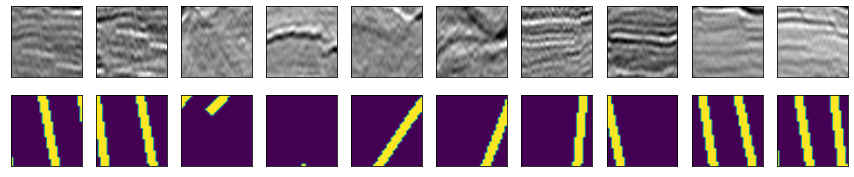

In [38]:
X_train_batch, Y_train_batch, mask_train_batch = next(datagen_train)


fig, axs = plt.subplots(2, 10, figsize=(15,3))

k = 0
for m in range(10):
  axs[0,m].imshow(X_train_batch[k,16,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[0,m].set_xticks([])
  axs[0,m].set_yticks([])
  k += 1

k = 0
for m in range(10):
  axs[1,m].imshow(Y_train_batch[k,16,:,:,0], interpolation='spline16', aspect=1)
  axs[1,m].set_xticks([])
  axs[1,m].set_yticks([])
  k += 1

And train our model:

In [36]:
# Define model
def down_block(x, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool3D((2, 2, 2), (2, 2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling3D((2, 2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c



def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input((size, size, size, 1))
  
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
  
    bn = bottleneck(p4, f[4])
  
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
  
    outputs = tf.keras.layers.Conv3D(1, (1, 1, 1), padding="same", activation=None)(u4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

model = UNet()

logits = model(data3D)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.AUTO)


model.compile(optimizer="adam", loss=loss, metrics=["acc"])

model.fit(datagen_train, epochs=10)

NameError: ignored